#### Summary
Takes trained model (from Luke).

On each "trial" takes 1 sample + N(e.g. 20) test, where exactly one of the 20 is the same class as in the sample.

Finds the 1 in the N that matches the sample the best, based on the posterior predictive probabilities

In [ ]:
testdata_numpy = np.fromfile("examples/mnist/data/binarized_mnist_test.amat", dtype=np.int16).reshape(-1,1,28,28)

1) get encodings for all train characters

2) build model using those training characters

3) classify test characters




got 100 instances
Loaded model.p


/Users/lucastian/miniconda3/envs/babyglot/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'helmholtz.WSR' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/lucastian/miniconda3/envs/babyglot/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'examples.mnist.mnist.PxIID' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


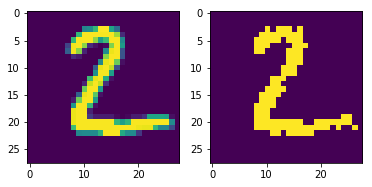

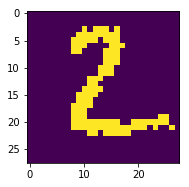

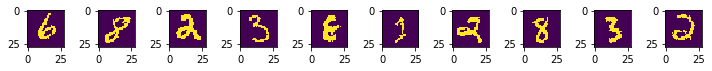

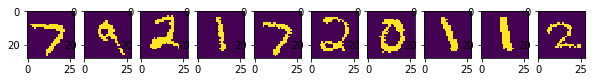

In [2]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import examples.mnist as M
import numpy as np

model=torch.load("./model.p", map_location='cpu') #LT
print("Loaded model.p")



## ==== REPLACE M.testdata WITH TORCHVISION MNIST DATA, so that have accurate labels.
# scale by 255, sample from bernoulli with those p, in order to binarize.


import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

mnist_test = datasets.MNIST(root='./data', train=False, download=True)
mnist_test.test_data = mnist_test.test_data.reshape(-1, 1, 28, 28)

# ===== BINARIZES THE DATASET
from torch.distributions.bernoulli import Bernoulli
mnist_bin = Bernoulli(mnist_test.test_data.to(torch.float64)/255).sample()

plt.figure()
plt.subplot(121)
plt.imshow(mnist_test.test_data.to(torch.float64)[1][0])
plt.subplot(122)
plt.imshow(mnist_bin[1][0])

mnist_test.test_data = mnist_bin

mnist_test.test_data.to(torch.uint8)
mnist_test.test_data[0][0]

plt.figure()
plt.subplot(121)
plt.imshow(mnist_test.test_data[1][0])

# ========= PERFORM REPLACEMENT
n = M.testdata.shape[0]
M.testdata = mnist_test.test_data[0:n]
M.testlabels = mnist_test.test_labels[0:n]


## ===== COMPARE original binarized dataset (above, train) vs. one that I made (below, test)

plt.figure(figsize=(10,20))
indthis = np.random.randint(low=0, high=100, size=10)
for i, ind in enumerate(indthis):
    plt.subplot(1,10,i+1)
    plt.imshow(M.data[ind][0].numpy().reshape(28, 28), vmin=0, vmax=1)
    plt.tight_layout()
    
plt.figure(figsize=(10,20))
for i, ind in enumerate(indthis):
    plt.subplot(1,10,i+1)
    plt.imshow(M.testdata[ind][0].numpy().reshape(28, 28), vmin=0, vmax=1)
##    plt.tight_layout()

# Classification code below

## define a function that loads appropriate characters

def getIdx(charSamp, M, Nway=20):    
#     charSamp = 1 # the sample integer (0,...,9)
#     Nway = 20 # how many test characters (only 1 will match the Samp)

    charSamp = torch.tensor(np.array(charSamp))
    
    # get sample
    a = np.where(M.testlabels==charSamp)
    idx_sample, idx_testmatch = np.random.choice(a[0], size=2, replace=False)

    # get the N-1 test that do not match the sample
    a = np.where(M.testlabels!=charSamp)
    idx_testnonmatch = np.random.choice(a[0], size=Nway-1, replace=False)
    
    return idx_sample, idx_testmatch, idx_testnonmatch


idx_sample, idx_testmatch, idx_testnonmatch = getIdx(1, M)




In [ ]:
charSamp = 4
Nway=10

## FUNCTION to computer posteriors
idx_sample, idx_testmatch, idx_testnonmatch = getIdx(charSamp = charSamp, M=M, Nway=Nway)
# concatenate them so that can run all together
idx_all = np.concatenate((idx_sample.reshape(1), idx_testmatch.reshape(1), idx_testnonmatch))

# get latent for 1-sample
c_all, _ = model.encoder(i=np.arange(len(idx_all)), x=M.testdata[idx_all])
# c_all, _ = model.encoder(i=np.arange(len(idx_all)), x=M.testdata[idx_all])

In [ ]:
# likelihoods for N-tests - HERE: EACH CHAR USING ITS OWN MODEL.
noiseval = 0.25
sample_probs=True
NiterNoise = 5
score_all = []
for n in range(NiterNoise):
    x_decod, score = model.decoder(i=np.arange(len(idx_all)), c=c_all, x=M.testdata[idx_all], 
                             noise=noiseval, sample_probs=sample_probs)
    score_all.append(score.detach().numpy())

score_all = [ss.reshape(1,-1) for ss in score_all]
score_all = np.concatenate(score_all)

plt.figure(figsize=(20, 5))
plt.plot(score_all.T, '-o')

plt.figure(figsize=(20,5))
for j, xx in enumerate(M.testdata[idx_all]):
    plt.subplot(1,len(idx_all),j+1)
    plt.title('orig%s' % j)
    plt.imshow(xx.numpy().reshape(28, 28), vmin=0, vmax=1)   
    
plt.figure(figsize=(20,5))
for j, xx in enumerate(x_decod):
    plt.subplot(1,len(idx_all),j+1)
    plt.title('decod%s' % j)
    plt.imshow(xx.detach().numpy().reshape(28, 28), vmin=0, vmax=1)   
    

# -underlay with the images of the characters

In [ ]:
# DIFFERENT - HERE, MODEL FOR THE FIRST CHARACTER, AGAINST THE OTHERS.
# This illustrates the problem:
# the image that is decoded using model.decoder() is entirely derived from the c that are input. 
c_onlyfirst = [c[0] for _ in range(len(idx_all))]


noiseval = 0
sample_probs=True
NiterNoise = 5
score_all = []
for n in range(NiterNoise):
    x_decod, score = model.decoder(i=np.arange(len(idx_all)), c=c_onlyfirst, x=M.testdata[idx_all], 
                                   noise=noiseval, sample_probs=sample_probs)
    score_all.append(score.detach().numpy())

score_all = [ss.reshape(1,-1) for ss in score_all]
score_all = np.concatenate(score_all)

plt.figure(figsize=(20, 5))
plt.plot(score_all.T, '-o')

plt.figure(figsize=(20,5))
for j, xx in enumerate(M.testdata[idx_all]):
    plt.subplot(1,len(idx_all),j+1)
    plt.title('orig%s' % j)
    plt.imshow(xx.numpy().reshape(28, 28), vmin=0, vmax=1)   
    
plt.figure(figsize=(20,5))
for j, xx in enumerate(x_decod):
    plt.subplot(1,len(idx_all),j+1)
    plt.title('decod%s' % j)
    plt.imshow(xx.detach().numpy().reshape(28, 28), vmin=0, vmax=1)   
    

# -underlay with the images of the characters

In [ ]:
## HERE: using the same i, but conditioning on each model differnetly
## doesn't work - given some i, will give the same output each time... [for the decoder]. 

noiseval = 0
sample_probs=True
NiterNoise = 5
score_all = []
for n in range(NiterNoise):
    ctmp, x_decod = model.sample(i=[idx_all[0] for _ in range(len(idx_all))], x=M.testdata[idx_all],
                                sample_probs=sample_probs)
    
    _, score = model.decoder(i=np.arange(len(idx_all)), c=c_all, x=M.testdata[idx_all], 
                                   noise=noiseval, sample_probs=sample_probs)
    score_all.append(score.detach().numpy())

score_all = [ss.reshape(1,-1) for ss in score_all]
score_all = np.concatenate(score_all)

plt.figure(figsize=(20, 5))
plt.plot(score_all.T, '-o')

plt.figure(figsize=(20,5))
for j, xx in enumerate(M.testdata[idx_all]):
    plt.subplot(1,len(idx_all),j+1)
    plt.title('orig%s' % j)
    plt.imshow(xx.numpy().reshape(28, 28), vmin=0, vmax=1)   
    
plt.figure(figsize=(20,5))
for j, xx in enumerate(x_decod):
    plt.subplot(1,len(idx_all),j+1)
    plt.title('decod%s' % j)
    plt.imshow(xx.detach().numpy().reshape(28, 28), vmin=0, vmax=1)   
    

# -underlay with the images of the characters

## Summary so far:
Am not sure how to "refit" a given model to different characters. The first method I tried (i.e. fix c, then decode conditioned on other characters) doesn't work, since c entirely determines the outpt. I think I need use the posterior for a given character (e.g. infer 10 of those guys to estimate the posterior, then sample from that). The plan of doing inference to get c, and then refitting that to all images does not work. 



In [ ]:
# ===== clear all model mixtures


In [ ]:
model(i=np.arange(len(idx_all)), x=M.testdata[idx_all[0]].repeat(len(idx_all),1,1,1))


In [ ]:
log_probs = model(i=np.arange(len(idx_all)), x=M.testdata[idx_all])
model(i=np.arange(len(idx_all))+3, x=M.testdata[idx_all[0]].repeat(len(idx_all),1,1,1))


In [ ]:
idx_all
x=M.testdata[j:j+1].repeat(100, 1, 1, 1)

In [340]:
model.conditional(i=np.array(idx_all[0:1]), D=x_all[0:1], x=x_all[0:1])

RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [362]:
idx_all = np.concatenate((idx_sample.reshape(1), idx_testmatch.reshape(1), idx_testnonmatch))

a = [model.conditional(i=np.array(idx_all[0:1]), D=x_all[0:1], x=x_all[kk:kk+1]) for kk in range(1, 3)]
print(a)

a = np.concatenate([aa.detach().numpy() for aa in a])
a = torch.tensor(a)
print(a)


TypeError: conditional() got an unexpected keyword argument 'noise'

In [363]:
a = [model.conditional(i=np.array(idx_all[0:1]), D=x_all[0:1], x=x_all[kk:kk+1]) for kk in range(1, 3)]
a

[tensor([-395.5370], grad_fn=<LogsumexpBackward>),
 tensor([-386.7137], grad_fn=<LogsumexpBackward>)]

In [3]:
## ===== ZEROTH, extract indices in test set that you want to work with
def getClassScore(charSamp, Nway=10, frontierSize=5, nUpdates=10, plotON=False):
# charSamp = 3 # which digit to use for the sample?
# Nway=15
# frontierSize = 5; how many components to remember

    # ========== GET RANDOM SAMPLES
    # IN ORDER: (sample, same_as_sample, diff_from_sample)
    idx_sample, idx_testmatch, idx_testnonmatch = getIdx(charSamp = charSamp, M=M, Nway=Nway)
    idx_all = np.concatenate((idx_sample.reshape(1), idx_testmatch.reshape(1), idx_testnonmatch))


    # EXTRACT DATA
    x_samp = M.testdata[idx_all[0]] # sample
#     x_test = [M.testdata[ii] for ii in idx_all[1:]] # need to already be updated in the model.
    x_all = [M.testdata[ii] for ii in idx_all] # need to already be updated in the model.
    # idx_all = range(len(idx_all))


    # ====== FIRST, EMPTY MIXTURE COMPONENTS
    model.frontierSize = frontierSize
    from torch.nn import Parameter
    model.mixtureComponents = [[] for _ in range(len(M.testdata))]
    model.mixtureWeights = Parameter(torch.zeros(len(M.testdata), model.frontierSize)) #Unnormalised log-q
    model.mixtureScores = [[] for _ in range(len(M.testdata))] #most recent log joint
    model.nMixtureComponents = Parameter(torch.zeros(len(M.testdata)))


    ## ===== FIRST, need to update model with posteriors for the novel stimuli    
    if plotON is True:
        print(model.mixtureWeights[idx_all[0]])
    model.makeUpdates(i=idx_all, x=x_all, nUpdates=nUpdates)
    if plotON is True:
        print(model.mixtureWeights[idx_all[0]])

    ## TESTING CLASSIFICATION ACCURACY
    
    # x_samp = M.testdata[idx_all[0]] # sample
    # x_test = [M.testdata[ii] for ii in idx_all] # need to already be updated in the model.
    # scores = model.conditional(idx_all, x_test, [x_samp]*(len(idx_all)-1))
    scores = model.conditional(i=idx_all, D=x_all, x=[x_samp]*(len(idx_all))) # use model for D to predict x_samp
    
    scores_sampmodel = [model.conditional(i=np.array(idx_all[0:1]), D=x_all[0:1], x=x_all[kk:kk+1]) for kk in range(0, len(x_all))]
    scores_sampmodel = torch.tensor(np.concatenate([aa.detach().numpy() for aa in scores_sampmodel]))

    scores_sum = scores_sampmodel + scores
    # ======== FOR EACH TEST CHARACTER, GET ITS SCORE 
    if plotON is True:
        plt.figure()
        plt.plot(scores.detach().numpy(), '-ok')
        # predictive += scores[0].mean().item() #.item() so we don't hold onto tensor for gradient information
        # if not (scores>scores[0]).any():
        #     num_tied = (scores==scores[0]).sum().item()
        #     hits += 1/num_tied 
        # total += 1

        # print("Took", int(time.time()-starttime), "seconds")
        # print(hits / total) # hit rate
        # print(predictive/total) # mean score
    print(scores)
    print(idx_all)
    return scores, scores_sampmodel, idx_all, scores_sum

hits = 0
total = 0
predictive = 0


In [ ]:
Ntrials = 5000
import pickle
charall = np.random.randint(0, 10, Ntrials)

for w, f, u in zip([5, 5, 10, 10, 20, 20],[5, 10, 5, 10, 5, 10],[20, 20, 20, 20, 20, 20]):
    scores_all = []
    scores_sampmodel_all = []
    scores_sum_all = []
    idx_all = []
    for i, cc in enumerate(charall):
        print(i)
        cc = np.array(cc)
        scores, scores_sampmodel, idx, scores_sum = getClassScore(charSamp=cc, Nway=w, frontierSize=f, nUpdates=u, plotON=False)

        scores_all.append(scores)
        scores_sampmodel_all.append(scores_sampmodel)
        scores_sum_all.append(scores_sum)
        idx_all.append(idx)


    ## ========= SAVE OUTPUT
    datall = [scores_all, scores_sampmodel, scores_sampmodel_all, idx_all]

    # ======== SAVE
    with open('./datsave/datall_w%sf%su%s' %(w, f, u), 'wb') as f:
        pickle.dump(scores_all, f)



0
tensor([-336.7109, -470.9560, -530.6036, -494.2357, -576.7020, -505.0817],
       grad_fn=<LogsumexpBackward>)
[1489 1953 1191 1770   37 1578]
1
tensor([-313.6947, -310.2741, -386.8073, -456.8715, -509.8735, -395.3032],
       grad_fn=<LogsumexpBackward>)
[ 642  311  131  209 1769 1667]
2
tensor([-113.1956, -113.1953, -224.9538, -255.3053, -268.4096, -239.2993],
       grad_fn=<LogsumexpBackward>)
[1054  840 1606 1636  561 1639]
3
tensor([-369.6490, -535.5023, -625.8774, -520.5749, -388.2399, -484.5329],
       grad_fn=<LogsumexpBackward>)
[ 732 1921 1175  706 1438  216]
4
tensor([-186.2781, -191.9810, -184.6402, -281.8914, -246.5230, -167.2517],
       grad_fn=<LogsumexpBackward>)
[1707 1434  443 1604  899 1746]
5
tensor([-352.8997, -390.6707, -417.1821, -474.5471, -430.3980, -379.5011],
       grad_fn=<LogsumexpBackward>)
[ 813 1492 1279   69  967  382]
6
tensor([-361.2936, -360.3748, -443.4626, -402.6171, -457.6292, -453.5317],
       grad_fn=<LogsumexpBackward>)
[  72  659 1320 1

tensor([-384.7396, -227.4300, -412.4076, -491.1981, -420.7097, -382.3590],
       grad_fn=<LogsumexpBackward>)
[1490  493  247  636  564 1206]
58
tensor([-223.1062, -273.2331, -234.3360, -263.8045, -269.8188, -274.0951],
       grad_fn=<LogsumexpBackward>)
[1495 1442  190 1938  289 1184]
59
tensor([-335.7724, -362.8932, -467.7855, -402.0356, -515.0527, -411.3793],
       grad_fn=<LogsumexpBackward>)
[1506   82   40 1285  717 1320]
60
tensor([-360.1966, -402.7194, -368.9176, -499.2873, -355.1706, -394.7660],
       grad_fn=<LogsumexpBackward>)
[1915  609 1561  969  815 1816]
61
tensor([-196.5894, -221.7741, -236.7649, -238.1656, -190.8093, -300.4243],
       grad_fn=<LogsumexpBackward>)
[ 883 1134 1540  922 1454 1488]
62
tensor([-344.7590, -378.8436, -247.7482, -361.9138, -458.8726, -337.4819],
       grad_fn=<LogsumexpBackward>)
[1420 1818 1144  412 1720 1240]
63
tensor([-217.2337, -224.6496, -220.9985, -246.7787, -236.8204, -257.4558],
       grad_fn=<LogsumexpBackward>)
[1580  103 10

tensor([-433.4024, -404.1831, -294.5228, -408.5887, -465.1121, -364.1718],
       grad_fn=<LogsumexpBackward>)
[1018  591  234 1191  141 1003]
115
tensor([-246.3541, -286.5090, -268.5477, -247.7820, -254.5972, -260.0415],
       grad_fn=<LogsumexpBackward>)
[  62  214 1283 1609 1301 1294]
116
tensor([-361.9531, -407.5824, -451.8774, -421.6347, -408.6002, -351.5410],
       grad_fn=<LogsumexpBackward>)
[1233   53 1679 1029 1984 1552]
117
tensor([-310.1213, -373.1891, -317.1941, -311.4618, -323.9542, -308.0126],
       grad_fn=<LogsumexpBackward>)
[   4 1060 1840  373 1248  657]
118
tensor([-294.8443, -445.9961, -425.3525, -411.8590, -414.8930, -416.8287],
       grad_fn=<LogsumexpBackward>)
[ 867  646  232  937 1826 1972]
119
tensor([-338.5810, -353.4840, -365.5102, -419.9936, -297.3792, -420.6687],
       grad_fn=<LogsumexpBackward>)
[ 901  770  747 1152  144 1660]
120
tensor([-346.4246, -425.4426, -313.0562, -436.0266, -414.6186, -386.4753],
       grad_fn=<LogsumexpBackward>)
[1431 1

tensor([-274.2034, -299.8672, -332.5323, -343.2487, -379.4904, -286.6114],
       grad_fn=<LogsumexpBackward>)
[ 919 1689  153 1883 1013 1198]
171
tensor([-254.0038, -365.0697, -298.1848, -298.0920, -282.8015, -240.8156],
       grad_fn=<LogsumexpBackward>)
[ 244 1811 1325  771  425 1952]
172
tensor([-204.7788, -367.9218, -343.5928, -342.2339, -307.2643, -313.4373],
       grad_fn=<LogsumexpBackward>)
[ 307 1186 1267  897  803 1299]
173
tensor([-329.0336, -347.0395, -362.1044, -341.9450, -350.1760, -286.4014],
       grad_fn=<LogsumexpBackward>)
[1468  981  748 1384  500 1728]
174
tensor([-394.7944, -461.4981, -410.2266, -391.8783, -352.8454, -461.1085],
       grad_fn=<LogsumexpBackward>)
[ 658 1721 1166  322 1873 1970]
175
tensor([-240.4771, -282.8097, -321.7625, -333.6964, -272.6951, -281.3821],
       grad_fn=<LogsumexpBackward>)
[ 211  356 1269 1426 1873  527]
176
tensor([-114.6011, -225.9253, -281.1107, -113.3616, -229.1898, -153.0620],
       grad_fn=<LogsumexpBackward>)
[1897  

tensor([-246.7407, -186.5316, -252.3814, -297.0963, -327.4510, -235.2994],
       grad_fn=<LogsumexpBackward>)
[ 521  593  379 1833 1735 1430]
227
tensor([-342.9402, -412.8862, -408.2755, -343.1137, -397.3986, -392.1536],
       grad_fn=<LogsumexpBackward>)
[1683 1519   59  405  729  427]
228
tensor([-347.4972, -342.4520, -388.7188, -402.0280, -403.5005, -336.2815],
       grad_fn=<LogsumexpBackward>)
[1553  593  907  756 1997 1770]
229
tensor([-329.2657, -510.2373, -318.5026, -525.9637, -480.0239, -449.4565],
       grad_fn=<LogsumexpBackward>)
[ 248 1157  854  848  869  418]
230
tensor([-413.0350, -595.0626, -446.1947, -490.2368, -592.4783, -373.2358],
       grad_fn=<LogsumexpBackward>)
[ 233 1225 1768  269  903  789]
231
tensor([-312.9396, -237.7989, -307.6377, -328.9191, -293.0988, -405.0866],
       grad_fn=<LogsumexpBackward>)
[1705 1710  505  758 1167 1560]
232
tensor([-606.7878, -521.1677, -525.3314, -500.9763, -381.0210, -484.5401],
       grad_fn=<LogsumexpBackward>)
[ 390 1

tensor([-167.0054, -170.5191, -125.9843, -220.2337, -265.5378, -245.6880],
       grad_fn=<LogsumexpBackward>)
[1201  824 1741 1347 1544  558]
283
tensor([-393.5330, -360.1651, -381.8338, -438.5653, -474.2897, -345.6644],
       grad_fn=<LogsumexpBackward>)
[1800  217  109 1533 1169  958]
284
tensor([-304.7635, -532.3270, -568.1141, -477.3762, -537.6712, -528.0067],
       grad_fn=<LogsumexpBackward>)
[1333 1638 1127   66  697 1717]
285
tensor([-211.6436, -194.3205, -210.5154, -166.4055, -308.0728, -268.1491],
       grad_fn=<LogsumexpBackward>)
[ 669  493  822 1564  839   64]
286
tensor([-280.4745, -439.4589, -555.0067, -561.5945, -584.4683, -648.7014],
       grad_fn=<LogsumexpBackward>)
[1853 1532  907 1465 1426  409]
287
tensor([-263.5904, -316.6207, -278.9102, -157.8569, -236.3601, -348.9239],
       grad_fn=<LogsumexpBackward>)
[1007 1441  519 1100 1027 1690]
288
tensor([-131.7352, -136.1319, -220.8985, -195.8398, -215.9254, -228.6380],
       grad_fn=<LogsumexpBackward>)
[1633  

tensor([-295.4747, -366.5301, -485.7026, -323.5026, -436.0348, -320.1451],
       grad_fn=<LogsumexpBackward>)
[1802  635 1578  770 1088  381]
339
tensor([-442.9786, -421.1566, -515.3461, -608.2993, -577.8278, -498.8569],
       grad_fn=<LogsumexpBackward>)
[1841 1808  572   62 1579 1815]
340
tensor([-226.4301, -291.5148, -304.3001, -333.9861, -336.7257, -318.8712],
       grad_fn=<LogsumexpBackward>)
[1596 1105  513 1870 1300 1701]
341
tensor([-331.6701, -356.3526, -364.8782, -342.1158, -384.3773, -328.8179],
       grad_fn=<LogsumexpBackward>)
[ 491 1046 1726  344 1841  466]
342
tensor([-333.1772, -330.9411, -256.8898, -335.7727, -218.4557, -336.4041],
       grad_fn=<LogsumexpBackward>)
[1852  650  206  554 1236 1198]
343
tensor([-140.1680, -108.8599, -153.6632, -128.5127, -187.8526, -204.0933],
       grad_fn=<LogsumexpBackward>)
[1392  135  349  307  703 1825]
344
tensor([-338.4149, -364.1881, -348.5980, -305.8264, -346.3934, -316.4589],
       grad_fn=<LogsumexpBackward>)
[ 829  

In [ ]:
dat = [scores_all, scores_sampmodel, scores_sampmodel_all, idx_all]
with open('./datsave/M', 'wb') as f:
    pickle.dump(dat, f)

66.66666666666666

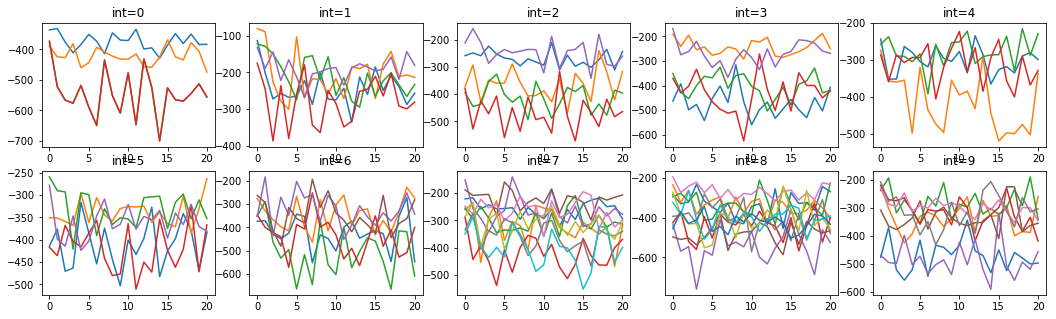

In [6]:
## SUMMARIZE CLASSIFICATION ERROR
# ===== 1) PLOT likelihood probabilites
plt.figure(figsize=(18, 5))

for nn in range(10):
    
    plt.subplot(2,5,nn+1)
    plt.title('int=%d' % nn)
    
#     scorestoplot = [scores_all[ii] for ii in range(len(idx_all)) if M.testlabels[idx_all[ii][0]]==nn] # trials with nn as trainsamp
#     plt.plot(scorestoplot, '-ok')
    
    trialsthis = [ii for ii in range(len(idx_all)) if M.testlabels[idx_all[ii][0]]==nn] # trials with nn as trainsamp
    
    for tt in trialsthis:
        plt.plot(scores_all[tt].detach().numpy(), '-')
        



(array([16.,  4., 14.,  7.,  2.,  6.,  5.,  3.,  5.,  1.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <a list of 10 Patch objects>)

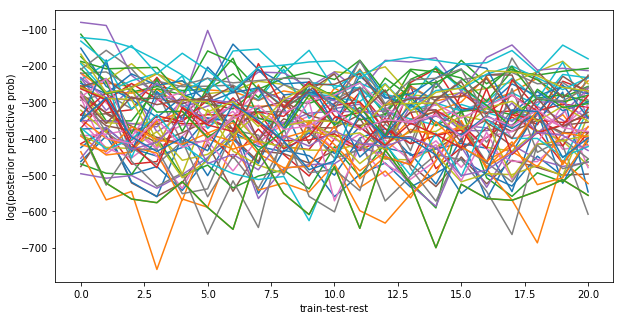

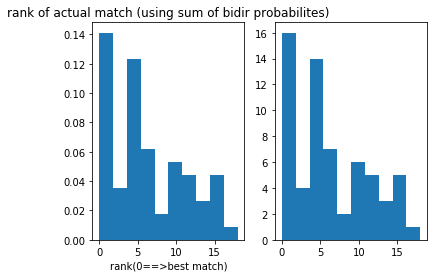

In [7]:
# ===== PLOT - combine across integers
plt.figure(figsize=(10, 5))
for ss in scores_all:
    plt.plot(ss.detach().numpy(), '-')
plt.xlabel('train-test-rest')
plt.ylabel('log(posterior predictive prob)')
# ==== Histogram of "rank" for the correct test
tmp = [sum(scores_all[i][1]>scores_all[i][2:]) for i in range(len(scores_all))]
rank = np.array(len(scores_all[0])-2)-tmp # ranges from 0 to NumOthers

plt.figure()

plt.subplot(1,2,1)
plt.hist(rank, density=True)
plt.title('rank of actual match (using sum of bidir probabilites)')
plt.xlabel('rank(0==>best match)')

plt.subplot(1,2,2)
plt.hist(rank, density=False)

    

tensor([8, 8, 6, 0, 5, 2, 2, 9, 5, 0, 5, 9, 1, 6, 5, 3, 6, 3, 6, 9, 2])

## BElow - scratch

tensor([0., 0., 0., 0., 0.], grad_fn=<SelectBackward>)
tensor([-313.4709, -359.4823, -394.6396, -407.2236, -232.0140],
       grad_fn=<SelectBackward>)


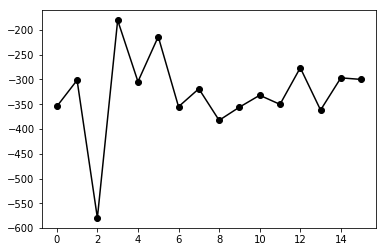

In [73]:
# ========== GET RANDOM SAMPLES
# IN ORDER: (sample, same_as_sample, diff_from_sample)
idx_sample, idx_testmatch, idx_testnonmatch = getIdx(charSamp = charSamp, M=M, Nway=Nway)
idx_all = np.concatenate((idx_sample.reshape(1), idx_testmatch.reshape(1), idx_testnonmatch))


# EXTRACT DATA
x_samp = M.testdata[idx_all[0]] # sample
#     x_test = [M.testdata[ii] for ii in idx_all[1:]] # need to already be updated in the model.
x_all = [M.testdata[ii] for ii in idx_all] # need to already be updated in the model.
# idx_all = range(len(idx_all))


# ====== FIRST, EMPTY MIXTURE COMPONENTS
model.frontierSize = 5
from torch.nn import Parameter
model.mixtureComponents = [[] for _ in range(len(M.testdata))]
model.mixtureWeights = Parameter(torch.zeros(len(M.testdata), model.frontierSize)) #Unnormalised log-q
model.mixtureScores = [[] for _ in range(len(M.testdata))] #most recent log joint
model.nMixtureComponents = Parameter(torch.zeros(len(M.testdata)))


## ===== FIRST, need to update model with posteriors for the novel stimuli
nUpdates=1
print(model.mixtureWeights[idx_all[0]])
model.makeUpdates(i=idx_all, x=x_all, nUpdates=nUpdates)
print(model.mixtureWeights[idx_all[0]])

## TESTING CLASSIFICATION ACCURACY

hits = 0
total = 0
predictive = 0

# x_samp = M.testdata[idx_all[0]] # sample
# x_test = [M.testdata[ii] for ii in idx_all] # need to already be updated in the model.
# scores = model.conditional(idx_all, x_test, [x_samp]*(len(idx_all)-1))
scores = model.conditional(i=idx_all, D=x_all, x=[x_samp]*(len(idx_all)))
# scores = model.conditional(range(len(x_all)), x_all, x_all)

plt.figure()
plt.plot(scores.detach().numpy(), '-ok')
# predictive += scores[0].mean().item() #.item() so we don't hold onto tensor for gradient information
# if not (scores>scores[0]).any():
#     num_tied = (scores==scores[0]).sum().item()
#     hits += 1/num_tied 
# total += 1

# print("Took", int(time.time()-starttime), "seconds")
# print(hits / total) # hit rate
# print(predictive/total) # mean score

In [ ]:
## ===== SECOND, get predictive probabilities
# THIS IS DOING FOR TRAINING DATA...

import time
## HEWITT FUNCTION
n_samples = 100
n_way = 50

n_samples = min(n_samples, len(M.data))
n_way = min(n_way, len(M.data))
print("Evaluating %d-way classification accuracy"%n_way, flush=True)
starttime=time.time()
#i = list(range(len(testM.data)))

hits = 0
total = 0
predictive = 0
for trueclass in range(n_samples): #100 classes np.random.choice(range(len(testM.data)), size=500, replace=False):
    x = M.data[trueclass]
    others = list(range(trueclass)) + list(range(trueclass+1, len(M.data)))
    i_rearranged = [trueclass] + list(np.random.choice(others, size=n_way-1, replace=False))
    x_inp = [M.data[ii] for ii in i_rearranged] # need to already be updated in the model.
    scores = model.conditional(i_rearranged, x_inp, [x]*n_way)
    predictive += scores[0].mean().item() #.item() so we don't hold onto tensor for gradient information
    #print("scores:", scores)
    if not (scores>scores[0]).any():
        num_tied = (scores==scores[0]).sum().item()
        hits += 1/num_tied 
    total += 1
print("Took", int(time.time()-starttime), "seconds")
print(hits / total) # hit rate
print(predictive/total) # mean score